In [1]:
import xml.etree.ElementTree as ET
from PIL import Image
import os
import pandas as pd
import numpy as np
import json
from tqdm.notebook import tqdm
import cv2
import matplotlib.pyplot as plt

In [2]:
absolute_path = 'D:\\Datasets\\NCAA\\NCAA_1_jersey'
crop_path = 'D:\\Datasets\\crops'
img_folder_path = 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames'
cor_path = 'D:\\Datasets\\NCAA\\NCAA_1_jersey\\data\\tracksVisualised'

if not os.path.exists(crop_path):
    os.makedirs(crop_path)

file_name = '.json'
jpeg_name = '.jpg'

anno_pathses = {}
img_pathses = {}
# пройдемся рекурсивно по всем папкам, начиная с absolute_path
for root, dirs, files in os.walk(absolute_path):    

    # проверяем, есть ли заданный файл в списке файлов текущей папки
    
    #(folder_name[1] in root) & ('frames' in root)  & 

    for file in files:

        folder_name = os.path.split(root)

        if file_name in file:
            # если есть, то добавляем путь в список
            anno_pathses[folder_name[1]] = root

for root, dirs, files in os.walk(img_folder_path):

    for file in files:

        folder_name = os.path.split(root)

        if jpeg_name in file:

            img_pathses[folder_name[1]] = root

print(img_pathses)
print(anno_pathses)

{'2018-11-28_Virginia_at_Maryland': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2018-11-28_Virginia_at_Maryland', '2018.11.27-Indiana_at_Duke': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2018.11.27-Indiana_at_Duke', '2019-01-12_Tennessee_at_Florida': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2019-01-12_Tennessee_at_Florida', '2019-01-19_Virginia_at_Duke': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2019-01-19_Virginia_at_Duke', '2019-02-11_Virginia_at_North_Carolina': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2019-02-11_Virginia_at_North_Carolina', '2019-02-18_Virginia_at_VirginiaTech': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2019-02-18_Virginia_at_VirginiaTech', '2019-02-25_NotreDame_at_FloridaState': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrackingFrames\\2019-02-25_NotreDame_at_FloridaState', '2019-03-04_Virginia_at_Syracuse': 'D:\\Datasets\\NCAA\\NCAA_1_tracking\\playerTrack

In [4]:
num = 0
x = 0
alpha = 0.1
num = 0
annos_list = []
anno_dict = {'file_name': [], 'text': []}
pathes_list = []

for folder, path in tqdm(anno_pathses.items()):
    files = os.listdir(path)

    for file in files:
        if '.json' in file:
            anno = os.path.join(path, file)
            jpg_file = file.replace('.json', '.jpg')
            jpg_file = 'frame_' + jpg_file
            img_path = os.path.join(img_pathses[folder], jpg_file)
            img = Image.open(img_path)
        else:
            continue  

        with open(anno, 'r') as f:
            data = json.load(f)

        points = pd.read_json(json.dumps(data['shapes']))

        for _, shape in points.iterrows():
            out_file = {}    

            if shape["shape_type"] == "rectangle":                       
            
                label = shape['label']

                split_label = label.split('_')
                number = str(split_label[-1])

                if len(split_label) == 3:

                    [xtl, ytl], [xbr, ybr] = shape['points']
                    #print(label, split_label, anno, img_path)
                    x_dif = np.abs(xtl - xbr)
                    y_dif = np.abs(ytl - ybr)

                    xtl = int(xtl - alpha * (x_dif / 2))
                    xbr = int(xbr + alpha * (x_dif / 2))
                    ytl = int(ytl - alpha * (y_dif / 2))
                    ybr = int(ybr + alpha * (y_dif / 2))

                    # Сделаем кроп номера на футболке
                    cropped_image = img.crop((xtl, ytl, xbr, ybr))

                    if str(number) == '5(1)':
                        number = '5' 
                        
                    full_path = crop_path + '\\' + str(number)                

                    if not os.path.exists(full_path):
                        os.makedirs(full_path)

                    x = file.replace('.json', '')
                    res_path = full_path +'\\' + f'ncaa_{folder}-id{x}-{num}.jpg'
                    num += 1

                    annos_list.append(str(number))
                    pathes_list.append(res_path )
                    anno_dict['text'] = annos_list
                    anno_dict['file_name'] = pathes_list
                    #print(anno, img_path, x[-1], number, label)
                    cropped_image.save(res_path)

df = pd.DataFrame(anno_dict, index=None)
df.to_csv("anno_ncaa.csv")
df.head()  

  0%|          | 0/41 [00:00<?, ?it/s]

,file_name,text
0,D:\Datasets\crops\11\ncaa_2018-11-28_Virginia_...,11
1,D:\Datasets\crops\0\ncaa_2018-11-28_Virginia_a...,0
2,D:\Datasets\crops\33\ncaa_2018-11-28_Virginia_...,33
3,D:\Datasets\crops\12\ncaa_2018-11-28_Virginia_...,12
4,D:\Datasets\crops\11\ncaa_2018-11-28_Virginia_...,11


Отобразим проблемные картинки чтобы проверить ошибки в логике или разметке.

D:\Datasets\NCAA\NCAA_1_tracking\playerTrackingFrames\2019.03.14-ACC-Syracuse_at_Duke\frame_020405.jpg


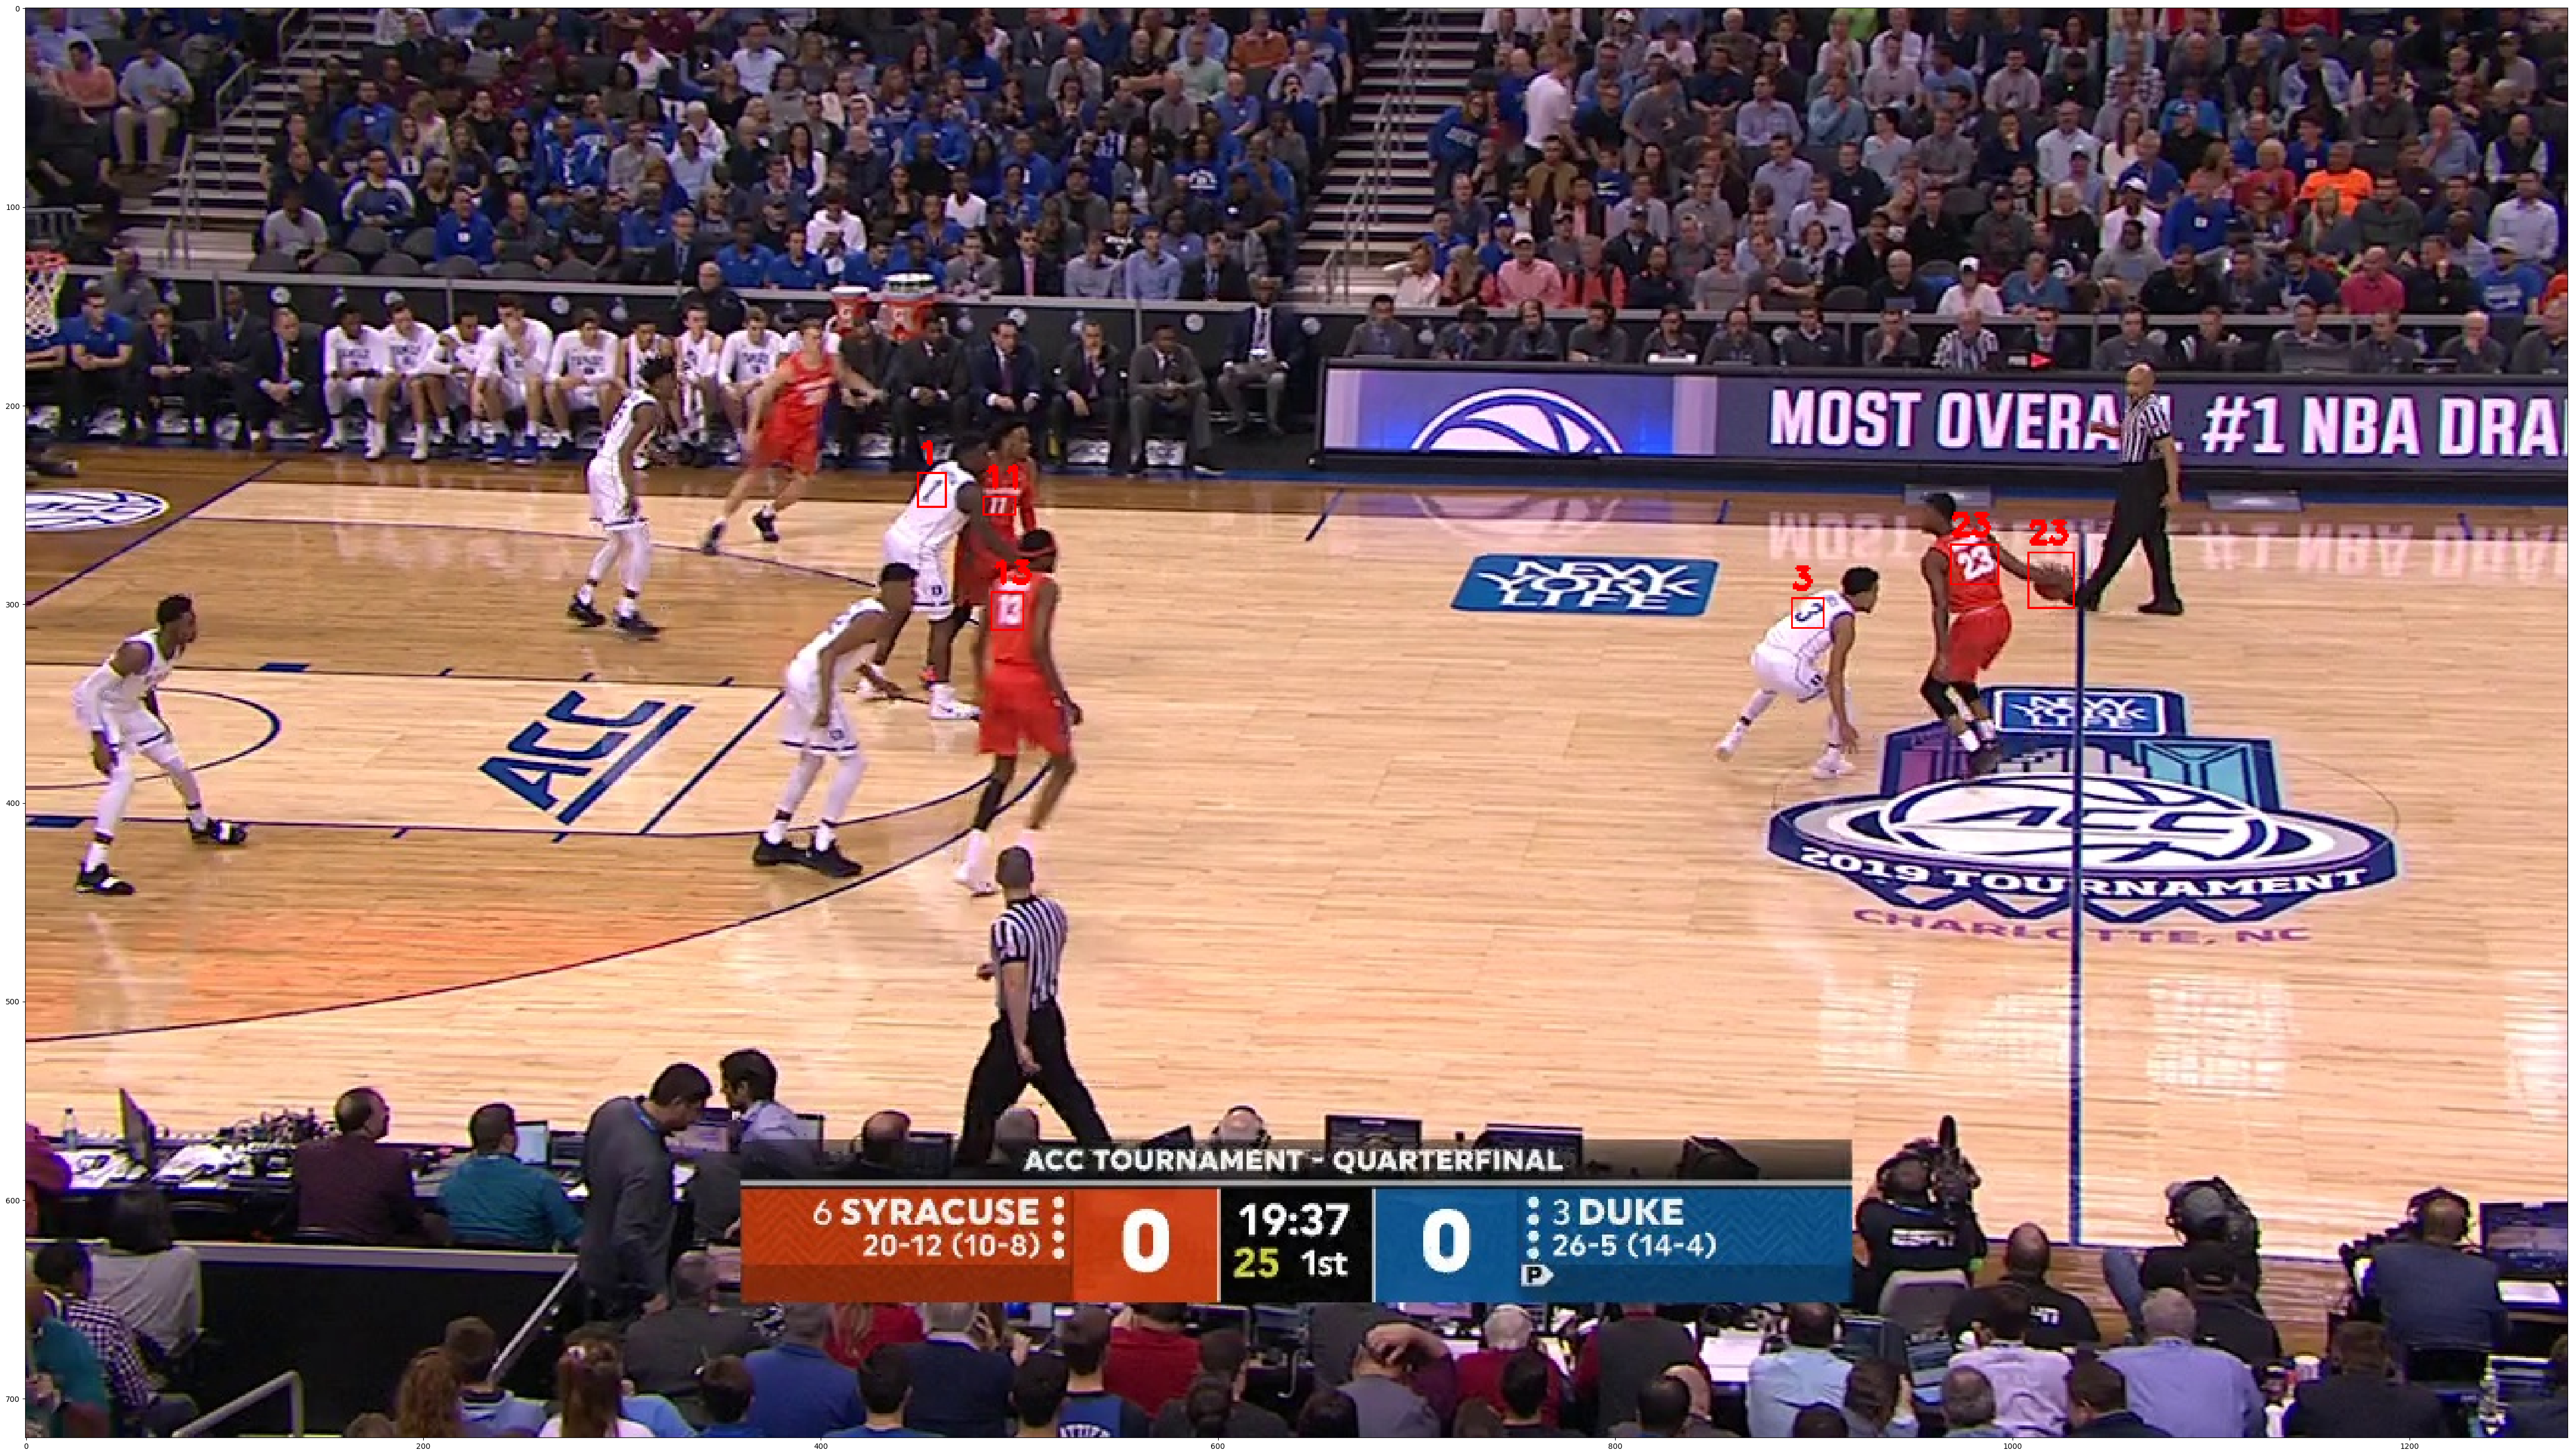

NameError: name 'anno_pathes' is not defined

In [7]:
name = '020405'
folder = '2019.03.14-ACC-Syracuse_at_Duke'

alpha = 0.1
num = 0
annos_list = []
anno_dict = {'file_name': [], 'text': []}
pathes_list = []

anno = anno_pathses[folder] + '\\' + name + '.json'
with open(anno, 'r') as f:
        data = json.load(f)

#Преобразуем json  в dataFrame
points = pd.read_json(json.dumps(data['shapes']))

file = 'frame_' + name + '.jpg'
img_path = os.path.join(img_pathses[folder], file)
print(img_path)
#img = Image.open(img_path)
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


for _, shape in points.iterrows():
        out_file = {}

        if shape["shape_type"] == "rectangle": 
                label = shape['label']            
                split_label = label.split('_')
                number = str(split_label[-1])

                if len(split_label) == 3:

                        point_obj = shape['points']
                        singl_point = point_obj
                        [xtl, ytl], [xbr, ybr] = singl_point

                        x_dif = np.abs(xtl - xbr)
                        y_dif = np.abs(ytl - ybr)

                        xtl = int(xtl - alpha * (x_dif / 2))
                        xbr = int(xbr + alpha * (x_dif / 2))
                        ytl = int(ytl - alpha * (y_dif / 2))
                        ybr = int(ybr + alpha * (y_dif / 2))

                        cv2.rectangle(img, (xtl, ytl), (xbr, ybr),color=(255, 0, 0) , thickness=1)
                        cv2.putText(img, number, (xtl, ytl - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

plt.subplots(figsize=(60, 60))
plt.imshow(img)
plt.show() 
print(anno_pathses[name])
